<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/MeasurePerformance_codechallenge_unequal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
#NEW!
import sklearn.metrics as skm

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [34]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [35]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

#normalize the data to a range of [0 1]
dataNorm=data/np.max(data)


Remove most of the 7's from the data

In [36]:
#FIND ALL THE 7's
where7s=np.where(labels==7)[0]
#how many to remove to leave 500 in the data
N2remove=where7s.shape[0]-500
#pick that number of 7's at random
remove7s=np.random.choice(where7s,N2remove,replace=False)
#and remove them form the data!
print('Sizes before removing:')
print(dataNorm.shape)
print(labels.shape)
dataNorm=np.delete(dataNorm,remove7s,axis=0)
labels=np.delete(labels,remove7s)
print('Sizes after removing:')
print(dataNorm.shape)
print(labels.shape)

Sizes before removing:
(20000, 784)
(20000,)
Sizes after removing:
(18374, 784)
(18374,)


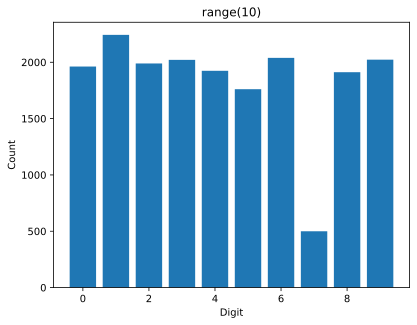

In [37]:
#see whether there is a roughtly equal number of elements in each category
#category
catcounts=np.unique(labels,return_counts=True)
#visualize
plt.bar(catcounts[0],catcounts[1])
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('range(10)')
plt.show()

remove them form the data

Create train/TEST GROUPS USING DataLoader

In [38]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Create the DL model

In [39]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,64)
      ###hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      ###output layer
      self.output = nn.Linear(32,10)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax(self.output(x),axis=1)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet()
  #loss function
  lossfun = nn.NLLLoss()
  #optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun, optimizer

Create a function that trains the model

In [40]:
# a function that trains the model
def function2trainTheModel():
  #number of epocs
  numepochs=10
  #create a new model
  net,lossfun,optimizer=createTheMNISTNet()
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Run the model and show the results

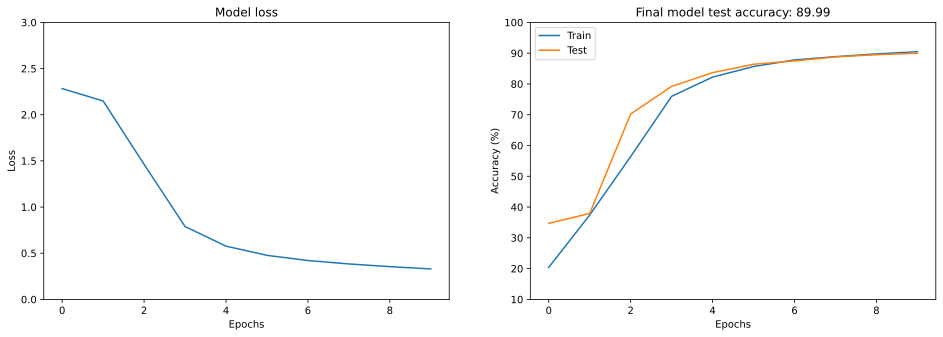

In [41]:
trainAcc, testAcc,losses, net=function2trainTheModel()
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}')
ax[1].legend()
plt.show()

Compute the performance measures on the train and test data

In [42]:
#predicted digits for training data
yHat=net(train_loader.dataset.tensors[0])
train_predictions=torch.argmax(yHat,axis=1)
#predicted digits for test data
yHat=net(test_loader.dataset.tensors[0])
test_predictions=torch.argmax(yHat,axis=1)


In [43]:
#brief aside on computing precision et al. in multiclass data:
#There are now 10 classes, so there are 10 precision values.
##option 1: compute precision for each class(each number)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average=None)
##option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
##option 3:compute   average precision, unweighted(same a 'weighted' if category N's are equal )
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='macro')


0.907307092659598

In [44]:
#New! using scikitlearn to compute ARPF
import sklearn.metrics as skm
#initialize vectors
train_metrics=[0,0,0,0]
test_metrics=[0,0,0,0]
#training
train_metrics[0]=skm.accuracy_score(train_loader.dataset.tensors[1],train_predictions)
train_metrics[1]=skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[2]=skm.recall_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[3]=skm.f1_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
#test
test_metrics[0]=skm.accuracy_score(test_loader.dataset.tensors[1],test_predictions,)
test_metrics[1]=skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[2]=skm.recall_score(test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[3]=skm.f1_score(test_loader.dataset.tensors[1],test_predictions,average='weighted')


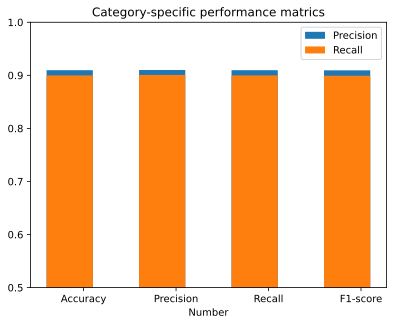

In [45]:
plt.bar(np.arange(4)-.15,train_metrics,.5)
plt.bar(np.arange(4)-.15,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.5,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance matrics')
plt.show()

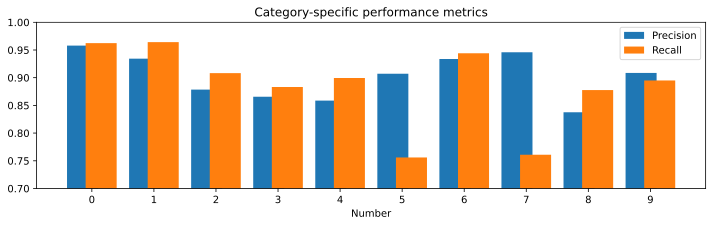

In [46]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall    = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average=None)


fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.7,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

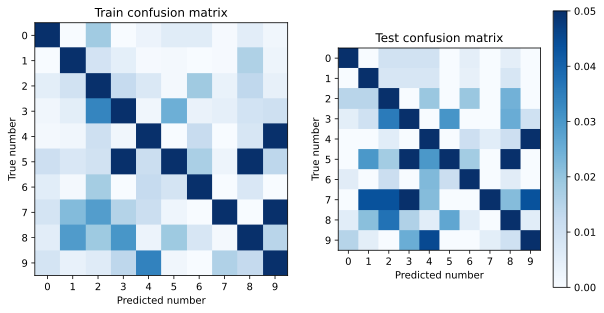

In [47]:
#confusion matrices
trainConf=skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf=skm.confusion_matrix(test_loader.dataset.tensors[1],test_predictions,normalize='true')
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('Train confusion matrix')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')
#confmat during test
a=ax[1].imshow(testConf,'Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('Test confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')
fig.colorbar(a)
plt.show()

